In [2]:
import pandas as pd
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import Choropleth, Marker, CircleMarker, Popup, GeoJson
import pydeck as pdk
import json

# 교수님 최종 완료하고 다시 처음부터 실행하는데 갑자기 패키지가 충돌하는건지 오류가 떠서 파일만 우선적으로 제출합니다..

# 1. 파일 불러오기 및 전처리

In [47]:
#파일 불러오기
import pandas as pd
df = pd.read_excel(
    r"C:\Users\jinuk\Downloads\아파트(전월세)_실거래가_20251110131628.xlsx",
    header=12
)
print(df.info())
list(df.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49472 entries, 0 to 49471
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NO            49472 non-null  int64  
 1   시군구           49472 non-null  object 
 2   번지            49472 non-null  object 
 3   본번            49472 non-null  int64  
 4   부번            49472 non-null  int64  
 5   단지명           49472 non-null  object 
 6   전월세구분         49472 non-null  object 
 7   전용면적(㎡)       49472 non-null  float64
 8   계약년월          49472 non-null  int64  
 9   계약일           49472 non-null  int64  
 10  보증금(만원)       49472 non-null  object 
 11  월세금(만원)       49472 non-null  object 
 12  층             49472 non-null  int64  
 13  건축년도          49472 non-null  int64  
 14  도로명           49472 non-null  object 
 15  계약기간          49472 non-null  object 
 16  계약구분          49472 non-null  object 
 17  갱신요구권 사용      49472 non-null  object 
 18  종전계약 보증금(만원)  8638 non-nul

['NO',
 '시군구',
 '번지',
 '본번',
 '부번',
 '단지명',
 '전월세구분',
 '전용면적(㎡)',
 '계약년월',
 '계약일',
 '보증금(만원)',
 '월세금(만원)',
 '층',
 '건축년도',
 '도로명',
 '계약기간',
 '계약구분',
 '갱신요구권 사용',
 '종전계약 보증금(만원)',
 '종전계약 월세(만원)',
 '주택유형']

In [48]:
df['전월세구분'].astype(str).value_counts()


전월세구분
전세    26679
월세    22793
Name: count, dtype: int64

In [49]:
df.columns = df.columns.str.strip()

need = [
    '전월세구분',
    '시군구',
    '계약년월',
    '보증금(만원)',
    '전용면적(㎡)'
]
df['전월세구분'] = df['전월세구분'].astype(str).str.strip()


In [50]:
# 시군구 분해
parts = df['시군구'].astype(str).str.split(expand=True)

df['시'] = parts[0]
df['구'] = parts[1]
df['동'] = parts[2]

# 혹시 동이 없는 케이스가 있으면 NaN일 수 있음(문제 아님)
df[['시군구','시','구','동']].head()
df['구'].value_counts().head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49472 entries, 0 to 49471
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NO            49472 non-null  int64  
 1   시군구           49472 non-null  object 
 2   번지            49472 non-null  object 
 3   본번            49472 non-null  int64  
 4   부번            49472 non-null  int64  
 5   단지명           49472 non-null  object 
 6   전월세구분         49472 non-null  object 
 7   전용면적(㎡)       49472 non-null  float64
 8   계약년월          49472 non-null  int64  
 9   계약일           49472 non-null  int64  
 10  보증금(만원)       49472 non-null  object 
 11  월세금(만원)       49472 non-null  object 
 12  층             49472 non-null  int64  
 13  건축년도          49472 non-null  int64  
 14  도로명           49472 non-null  object 
 15  계약기간          49472 non-null  object 
 16  계약구분          49472 non-null  object 
 17  갱신요구권 사용      49472 non-null  object 
 18  종전계약 보증금(만원)  8638 non-nul

# 2. 아파트 전월세 데이터에 대한 자치구별 통계적 분석 및 상관계수 그래프

## 

In [51]:
# 0) 기본 정리
df.columns = df.columns.str.strip()
df['전월세구분'] = df['전월세구분'].astype(str).str.strip()

# 1) 전세/월세 먼저 분리
df_jeon = df[df['전월세구분'] == '전세'].copy()
df_wol  = df[df['전월세구분'] == '월세'].copy()

# 2) 전세: 보증금/면적만 숫자 변환 + 결측 제거
df_jeon['보증금(만원)'] = pd.to_numeric(
    df_jeon['보증금(만원)'].astype(str).str.replace(',', ''), errors='coerce'
)
df_jeon['전용면적(㎡)'] = pd.to_numeric(df_jeon['전용면적(㎡)'], errors='coerce')

df_jeon = df_jeon.dropna(subset=['보증금(만원)', '전용면적(㎡)', '구'])
df_jeon = df_jeon[df_jeon['전용면적(㎡)'] > 0]

# 3) 월세: 보증금/월세/면적 숫자 변환 + 결측 제거
df_wol['보증금(만원)'] = pd.to_numeric(
    df_wol['보증금(만원)'].astype(str).str.replace(',', ''), errors='coerce'
)
df_wol['월세금(만원)'] = pd.to_numeric(
    df_wol['월세금(만원)'].astype(str).str.replace(',', ''), errors='coerce'
)
df_wol['전용면적(㎡)'] = pd.to_numeric(df_wol['전용면적(㎡)'], errors='coerce')

df_wol = df_wol.dropna(subset=['보증금(만원)', '월세금(만원)', '전용면적(㎡)', '구'])
df_wol = df_wol[df_wol['전용면적(㎡)'] > 0]

# ---- (디버그: 여기서 전세/월세 행 수 확인) ----
print("전세 rows:", len(df_jeon), " / 월세 rows:", len(df_wol))

# 4) 구별 평균 (월세)
num_cols_wol = ['보증금(만원)', '월세금(만원)', '전용면적(㎡)']
gu_wol = (
    df_wol.groupby('구')[num_cols_wol].mean().reset_index()
)
gu_wol['면적당보증금'] = gu_wol['보증금(만원)'] / gu_wol['전용면적(㎡)']
gu_wol['면적당월세']   = gu_wol['월세금(만원)'] / gu_wol['전용면적(㎡)']

top5_wol_rent = gu_wol.sort_values('면적당월세', ascending=False).head(5)
print('상위 월세 자치구')
print(top5_wol_rent[['구','월세금(만원)']].reset_index(drop=True))

top5_wol_dep = gu_wol.sort_values('면적당보증금', ascending=False).head(5)
print('상위 보증금 자치구 (월세)')
print(top5_wol_dep[['구','보증금(만원)']].reset_index(drop=True))

# 5) 구별 평균 (전세)
num_cols_jeon = ['보증금(만원)', '전용면적(㎡)']
gu_jeon = (
    df_jeon.groupby('구')[num_cols_jeon].mean().reset_index()
)
gu_jeon['면적당보증금'] = gu_jeon['보증금(만원)'] / gu_jeon['전용면적(㎡)']

top5_jeon = gu_jeon.sort_values('면적당보증금', ascending=False).head(5)
print('상위 보증금 자치구(전세)')
print(top5_jeon[['구','보증금(만원)']].reset_index(drop=True))


전세 rows: 26679  / 월세 rows: 22793
상위 월세 자치구
      구     월세금(만원)
0  해운대구  105.361331
1    동구   75.104762
2   수영구   80.072634
3    남구   79.535533
4  부산진구   54.739355
상위 보증금 자치구 (월세)
     구      보증금(만원)
0  연제구  6295.445783
1  동래구  5999.941136
2   남구  5643.888959
3  강서구  6025.462116
4   북구  4994.612053
상위 보증금 자치구(전세)
      구       보증금(만원)
0    남구  31314.417178
1   동래구  30138.129184
2    동구  26804.510234
3  해운대구  30917.760083
4   수영구  30290.603530


In [52]:
num_cols_wol = ['보증금(만원)', '월세금(만원)', '전용면적(㎡)']

gu_wol = (
    df_wol
    .groupby('구')[num_cols_wol]
    .mean()
    .reset_index()
)
gu_wol['면적당보증금'] = (gu_wol['보증금(만원)'] / gu_wol['전용면적(㎡)'])
gu_wol['면적당월세'] = (gu_wol['월세금(만원)'] / gu_wol['전용면적(㎡)'])

top5_wol = gu_wol.sort_values('면적당월세', ascending=False).head(5)
print('상위 월세 자치구')
print(top5_wol[['구','월세금(만원)']].reset_index(drop=True))

top5_wol = gu_wol.sort_values('면적당보증금', ascending=False).head(5)
print('상위 보증금 자치구 (월세)')
print(top5_wol[['구','보증금(만원)']].reset_index(drop=True))

상위 월세 자치구
      구     월세금(만원)
0  해운대구  105.361331
1    동구   75.104762
2   수영구   80.072634
3    남구   79.535533
4  부산진구   54.739355
상위 보증금 자치구 (월세)
     구      보증금(만원)
0  연제구  6295.445783
1  동래구  5999.941136
2   남구  5643.888959
3  강서구  6025.462116
4   북구  4994.612053


In [57]:
import pandas as pd
import altair as alt

df_wol = df[df['전월세구분'].astype(str).str.strip() == '월세'].copy()

num_cols = ['보증금(만원)', '월세금(만원)', '전용면적(㎡)']

# 1) 콤마 제거 + 숫자 변환
for c in num_cols:
    df_wol[c] = (
        df_wol[c].astype(str)
        .str.replace(',', '', regex=False)
        .str.strip()
    )
    df_wol[c] = pd.to_numeric(df_wol[c], errors='coerce')

# 2) 결측/0 제거 (면적 0이면 나중 계산도 터짐)
df_wol = df_wol.dropna(subset=num_cols)
df_wol = df_wol[df_wol['전용면적(㎡)'] > 0]

# 3) 상관계수 계산
corr_wol = df_wol[num_cols].corr().reset_index()
corr_wol = corr_wol.melt(id_vars='index', var_name='변수2', value_name='상관계수')
corr_wol.rename(columns={'index': '변수1'}, inplace=True)

base = alt.Chart(corr_wol).encode(
    x='변수1:O',
    y='변수2:O'
).properties(width=400, height=400, title='월세 데이터 변수 간 상관관계')

heatmap = base.mark_rect().encode(
    color=alt.Color('상관계수:Q').scale(scheme='redblue', domain=[-1, 1]).title('상관계수')
)

text = base.mark_text(align='center', baseline='middle', color='black').encode(
    text=alt.Text('상관계수:Q', format='.2f')
)

heatmap + text


alt.LayerChart(...)

### 해석
월세가 높을수록 전용 면적이 높아지는(약하게나마) 보였지만, 강한 상관관계를 갖진 않았고, 이외에도 월세금이 높다고 보증금이 낮는 등의 모습은
나타나지 않았다. 이는 월세와 보증금은 지리적 특성에 따라 가격이 정해지는 것이지 서로 큰 상관관계가 없다는 것을 알 수 있다.

# 3. 자치구별 아파트 전세/제곱미터 가격 변화

In [58]:
df['전월세구분'].astype(str).value_counts()


전월세구분
전세    26679
월세    22793
Name: count, dtype: int64

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49472 entries, 0 to 49471
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NO            49472 non-null  int64  
 1   시군구           49472 non-null  object 
 2   번지            49472 non-null  object 
 3   본번            49472 non-null  int64  
 4   부번            49472 non-null  int64  
 5   단지명           49472 non-null  object 
 6   전월세구분         49472 non-null  object 
 7   전용면적(㎡)       49472 non-null  float64
 8   계약년월          49472 non-null  int64  
 9   계약일           49472 non-null  int64  
 10  보증금(만원)       49472 non-null  object 
 11  월세금(만원)       49472 non-null  object 
 12  층             49472 non-null  int64  
 13  건축년도          49472 non-null  int64  
 14  도로명           49472 non-null  object 
 15  계약기간          49472 non-null  object 
 16  계약구분          49472 non-null  object 
 17  갱신요구권 사용      49472 non-null  object 
 18  종전계약 보증금(만원)  8638 non-nul

In [60]:
df_j = df[df['전월세구분'].astype(str).str.strip() == '전세'].copy()

# 월 만들기(안전)
df_j['계약년월'] = pd.to_numeric(df_j['계약년월'], errors='coerce')
df_j = df_j.dropna(subset=['계약년월'])
df_j['계약년월'] = df_j['계약년월'].astype(int)
df_j['거래월'] = (df_j['계약년월'] % 100).astype(str).str.zfill(2)

# 면적당 보증금
df_j['보증금(만원)'] = pd.to_numeric(df_j['보증금(만원)'].astype(str).str.replace(',', ''), errors='coerce')
df_j['전용면적(㎡)'] = pd.to_numeric(df_j['전용면적(㎡)'], errors='coerce')
df_j = df_j.dropna(subset=['보증금(만원)', '전용면적(㎡)'])
df_j = df_j[df_j['전용면적(㎡)'] > 0]

df_j['면적당보증금_만원'] = df_j['보증금(만원)'] / df_j['전용면적(㎡)']

# ✅ 월별-구별 평균
df_avg_j = (
    df_j.groupby(['거래월', '구'], as_index=False)['면적당보증금_만원']
        .mean()
)
df_avg_j


,거래월,구,면적당보증금_만원
0,01,강서구,223.579460
1,01,금정구,330.715914
2,01,기장군,314.653186
3,01,남구,377.519301
4,01,동구,372.485149
...,...,...,...
155,10,수영구,374.215482
156,10,연제구,419.479111
157,10,영도구,294.773859
158,10,중구,268.406893


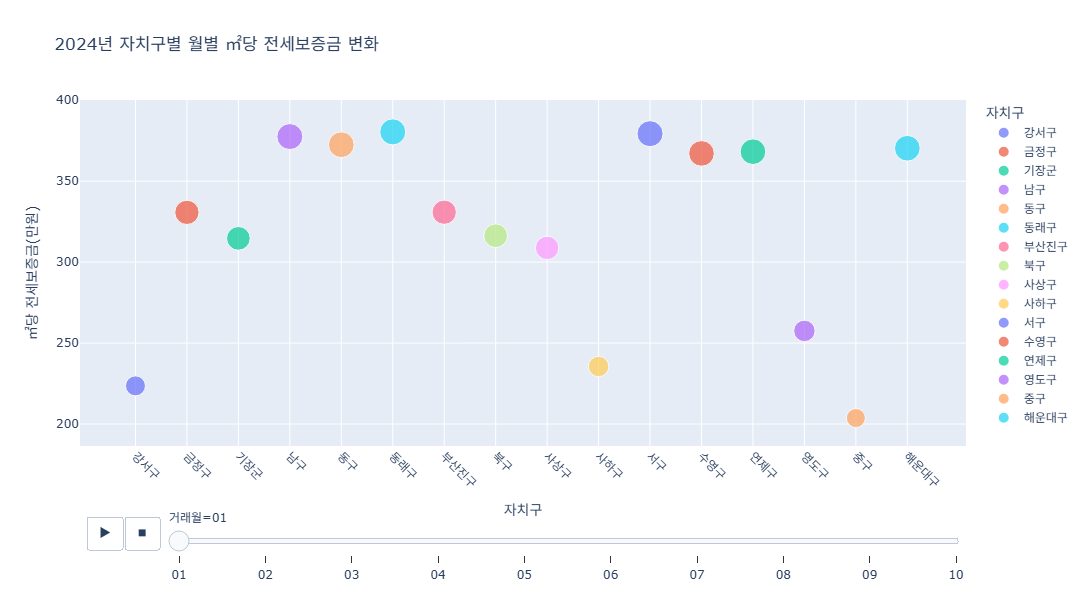

In [64]:

df_avg_j_clean = df_avg_j.dropna(subset=['면적당보증금_만원'])

fig = px.scatter(
    df_avg_j_clean,
    x='구',
    y='면적당보증금_만원',
    color='구',
    size='면적당보증금_만원',
    animation_frame='거래월',
    animation_group='구',
    hover_name='구',
    title='2024년 자치구별 월별 ㎡당 전세보증금 변화',
    labels={
        '면적당보증금_만원': '㎡당 전세보증금(만원)',
        '거래월': '거래월',
        '구': '자치구'
    }
)

fig.update_xaxes(tickangle=45)
fig.update_layout(width=1000, height=600)
fig.write_html("전세_slider.html")
fig.show()


### 어떤 이유에서인지 그래프가 뜨지않아서 html 파일로 압축하여 제출하겠습니다!

# 4. 자치구별 아파트 월세/제곱미터 가격의 변화 3D차트

In [65]:
import pandas as pd

df_w = df[df['전월세구분'].astype(str).str.strip() == '월세'].copy()

# 거래월
df_w['계약년월'] = pd.to_numeric(df_w['계약년월'], errors='coerce')
df_w = df_w.dropna(subset=['계약년월'])
df_w['거래월'] = (df_w['계약년월'].astype(int) % 100).astype(str).str.zfill(2)

# ✅ 숫자화(콤마 제거 + to_numeric)
df_w['월세금(만원)'] = pd.to_numeric(
    df_w['월세금(만원)'].astype(str).str.replace(',', '', regex=False),
    errors='coerce'
)
df_w['전용면적(㎡)'] = pd.to_numeric(df_w['전용면적(㎡)'], errors='coerce')

# ✅ 결측/0 제거
df_w = df_w.dropna(subset=['월세금(만원)', '전용면적(㎡)'])
df_w = df_w[df_w['전용면적(㎡)'] > 0]

# ㎡당 월세
df_w['월세_㎡당_만원'] = df_w['월세금(만원)'] / df_w['전용면적(㎡)']

# 월-구 평균
df_avg = (
    df_w.groupby(['거래월', '구'], as_index=False)['월세_㎡당_만원']
        .mean()
)

df_avg


,거래월,구,월세_㎡당_만원
0,01,강서구,0.809861
1,01,금정구,1.240851
2,01,기장군,0.930292
3,01,남구,1.345966
4,01,동구,1.310869
...,...,...,...
155,10,수영구,1.283462
156,10,연제구,0.884557
157,10,영도구,1.013140
158,10,중구,1.236467


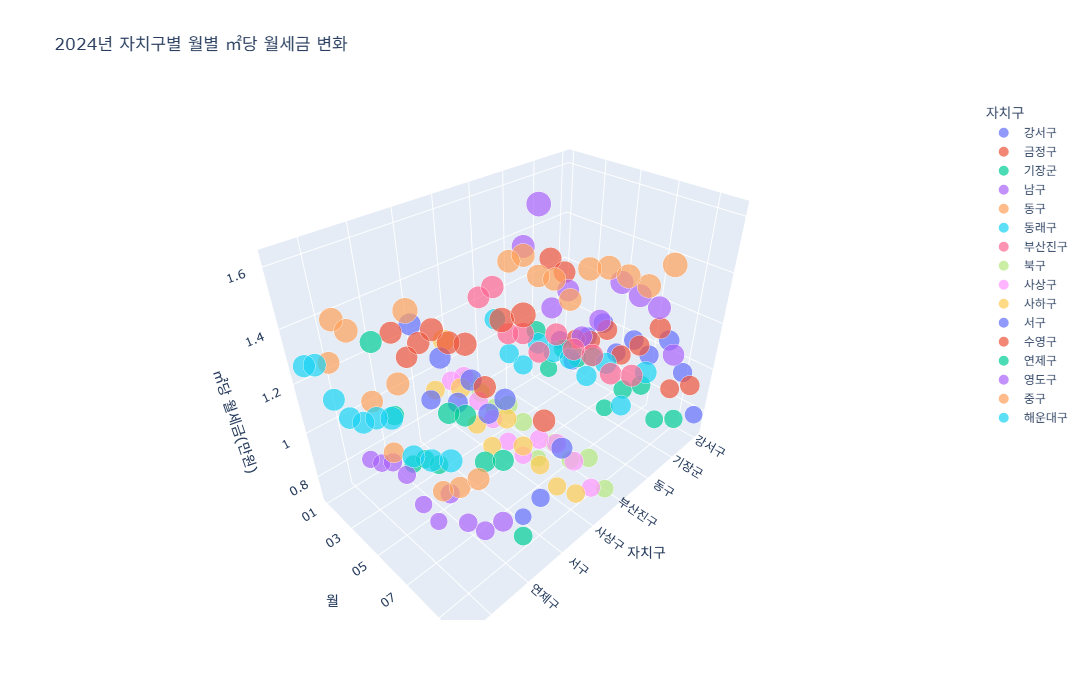

In [66]:
fig = px.scatter_3d(
    df_avg,
    x='구',
    y='거래월',
    z='월세_㎡당_만원',
    color='구',
    size='월세_㎡당_만원',
    hover_name='구',
    labels={
        '거래월':'월',
        '월세_㎡당_만원':'㎡당 월세금(만원)',
        '구':'자치구'
    },
    title='2024년 자치구별 월별 ㎡당 월세금 변화'
)

fig.update_layout(width=1000, height=700)
fig.show()
fig.write_html("월세_slider.html")


In [68]:
import pandas as pd

df_j = df[df['전월세구분'].astype(str).str.strip() == '전세'].copy()

# ✅ 숫자화(콤마 제거 + to_numeric)
df_j['보증금(만원)'] = pd.to_numeric(
    df_j['보증금(만원)'].astype(str).str.replace(',', '', regex=False).str.strip(),
    errors='coerce'
)
df_j['전용면적(㎡)'] = pd.to_numeric(df_j['전용면적(㎡)'], errors='coerce')

# ✅ 결측/0 제거
df_j = df_j.dropna(subset=['보증금(만원)', '전용면적(㎡)'])
df_j = df_j[df_j['전용면적(㎡)'] > 0]

# ✅ 면적당 보증금
df_j['면적당보증금_만원'] = df_j['보증금(만원)'] / df_j['전용면적(㎡)']

# ✅ 구별 평균
gu_avg_j = (
    df_j.groupby('구', as_index=False)['면적당보증금_만원']
        .mean()
)

gu_avg_j


,구,면적당보증금_만원
0,강서구,231.535604
1,금정구,331.625836
2,기장군,302.997669
3,남구,393.034107
4,동구,386.607507
5,동래구,392.675818
6,부산진구,340.718412
7,북구,313.007068
8,사상구,292.910929
9,사하구,251.274839


In [69]:
import json

with open(r"C:\Users\jinuk\OneDrive\바탕 화면\시각화_2차_김진욱_C321020\hangjeongdong_부산광역시.geojson", encoding='utf-8') as f:
    busan_geo = json.load(f)


dong_names = [f['properties']['adm_nm'] for f in busan_geo['features']]

for feature in busan_geo['features']:
    full_name = feature['properties']['adm_nm']   
    gu_name = full_name.split()[1]               
    feature['properties']['gu'] = gu_name       

### geojson 파일은 깃허브에서 받았습니다. 이 역시 zip에 묶어서 업로드 하도록 하겠습니다.

In [74]:
import folium

# 지도 생성
mappp = folium.Map(location=[35.1796, 129.0756], zoom_start=11, tiles='cartodbpositron')


folium.Choropleth(
    geo_data=busan_geo,
    data=gu_avg_j,
    columns=['구', '면적당보증금_만원'],
    key_on='feature.properties.gu',   # 새로 만든 구 속성 사용
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name='부산 구별 ㎡당 전세보증금 (만원)'
).add_to(mappp)

mappp

In [75]:
mappp.save("busan_전세_㎡당_보증금.html")


# 6. 자치구별 전세/제곱미터 가격에 대한 3D 

In [21]:
import numpy as np
centroids = []

for feature in busan_geo['features']:
    full_name = feature['properties']['adm_nm']
    gu_name = full_name.split()[1]  # '부산광역시 해운대구 우1동' -> '해운대구'
    
    # 다각형 좌표 가져오기
    coords = np.array(feature['geometry']['coordinates'][0])
    
    # 각 feature의 중심 좌표 계산
    lon, lat = coords[:,0].mean(), coords[:,1].mean()
    centroids.append({'구': gu_name, 'lat': lat, 'lon': lon})

# DataFrame으로 변환
df_centroids = pd.DataFrame(centroids)

# 구별 중복 제거 및 평균
df_centroids = df_centroids.groupby('구', as_index=False).agg({'lat':'mean','lon':'mean'})

df_centroids.head()

,구,lat,lon
0,강서구,82.043126,82.043817
1,금정구,82.174058,82.174785
2,기장군,82.267459,82.268106
3,남구,82.111685,82.112972
4,동구,82.088558,82.089030


In [22]:
# 6번은 완료하지 못했습니다.

In [23]:
https://chatgpt.com/share/69118980-3a84-8001-aae7-61705829e556

SyntaxError: invalid decimal literal (2674180812.py, line 1)